In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("crop_yield.csv")

In [3]:
crop_name = "Maize"
df_crop = df[df['Crop'].str.lower() == crop_name.lower()].copy()

In [4]:
df_crop.dropna(inplace=True) 

In [5]:
X = df_crop.drop(columns=["Crop", "Yield_tons_per_hectare"])

In [6]:
categorical_features = ['Region', 'Soil_Type', 'Weather_Condition', 'Fertilizer_Used', 'Irrigation_Used']
numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

In [9]:
X_processed = preprocessor.fit_transform(X)

In [13]:
silhouette_scores = []
K_range = range(2, 7)

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

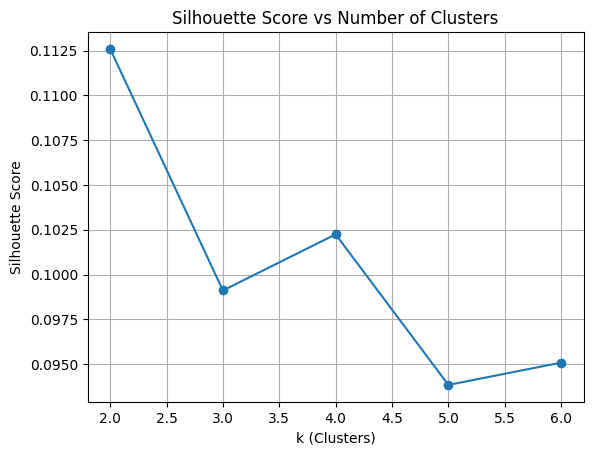


✅ Optimal number of clusters based on silhouette: 2

📊 Cluster Summary (with Avg Yield):
   Cluster  Avg_Yield  Min_Yield  Max_Yield  Samples  Rainfall_mm  \
0        0       4.77      -0.34       9.95    83374        549.1   
1        1       4.52      -0.88       9.83    83450        549.3   

   Temperature_Celsius  Days_to_Harvest Region Soil_Type  Fertilizer_Used  \
0                 33.7            104.4  North     Sandy            False   
1                 21.2            104.7  North      Loam            False   

   Irrigation_Used Weather_Condition  
0             True             Rainy  
1            False             Sunny  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv("crop_yield.csv") 

crop_name = "Maize"
df_crop = df[df['Crop'].str.lower() == crop_name.lower()].copy()

df_crop.dropna(inplace=True)

yield_col = df_crop["Yield_tons_per_hectare"]

X = df_crop.drop(columns=["Crop", "Yield_tons_per_hectare"])

categorical_features = ['Region', 'Soil_Type', 'Weather_Condition', 'Fertilizer_Used', 'Irrigation_Used']
numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


X_processed = preprocessor.fit_transform(X)

silhouette_scores = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    silhouette_scores.append(score)


plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k (Clusters)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✅ Optimal number of clusters based on silhouette: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_crop['Cluster'] = kmeans.fit_predict(X_processed)

df_crop["Yield_tons_per_hectare"] = yield_col

yield_stats = df_crop.groupby("Cluster")["Yield_tons_per_hectare"].agg(
    Avg_Yield="mean",
    Min_Yield="min",
    Max_Yield="max",
    Samples="count"
).round(2)

input_means = df_crop.groupby("Cluster")[[
    "Rainfall_mm", "Temperature_Celsius", "Days_to_Harvest"
]].mean().round(1)

categorical_modes = df_crop.groupby("Cluster")[[
    "Region", "Soil_Type", "Fertilizer_Used", "Irrigation_Used", "Weather_Condition"
]].agg(lambda x: x.mode()[0])

# Combine everything
cluster_summary = pd.concat([yield_stats, input_means, categorical_modes], axis=1).reset_index()

# Display summary
print("\n📊 Cluster Summary (with Avg Yield):")
print(cluster_summary)


In [18]:
pip install kmodes


# K-Prototypes Clustering

In [ ]:
import pandas as pd
import numpy as np
import json
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("crop_yield.csv") 

categorical_cols = ['Region', 'Soil_Type', 'Weather_Condition', 'Fertilizer_Used', 'Irrigation_Used']
numerical_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
target_col = 'Yield_tons_per_hectare'

for col in categorical_cols:
    df[col] = df[col].astype(str)

cluster_summaries = {}

for crop in df['Crop'].unique():
    df_crop = df[df['Crop'] == crop].dropna().copy()
    
    if len(df_crop) < 10:
        continue  
    
    yield_data = df_crop[target_col].astype(float)

    X_cat = df_crop[categorical_cols]
    X_num = df_crop[numerical_cols]
    
  
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numerical_cols)


    X_combined = pd.concat([X_cat.reset_index(drop=True), X_num_scaled.reset_index(drop=True)], axis=1).values

    kproto = KPrototypes(n_clusters=3, init='Huang', verbose=0, random_state=42)
    clusters = kproto.fit_predict(X_combined, categorical=list(range(len(categorical_cols))))
 
    df_crop['Cluster'] = clusters
    df_crop[target_col] = yield_data

    summary = []
    for cluster_id, group in df_crop.groupby('Cluster'):
        avg_yield = round(group[target_col].mean(), 2)
        summary.append({
            "Cluster": int(cluster_id),
            "Region": group['Region'].mode()[0],
            "Soil_Type": group['Soil_Type'].mode()[0],
            "Weather_Condition": group['Weather_Condition'].mode()[0],
            "Fertilizer_Used": group['Fertilizer_Used'].mode()[0],
            "Irrigation_Used": group['Irrigation_Used'].mode()[0],
            "Avg_Rainfall": round(group['Rainfall_mm'].mean(), 1),
            "Avg_Temperature": round(group['Temperature_Celsius'].mean(), 1),
            "Avg_Harvest_Days": round(group['Days_to_Harvest'].mean(), 1),
            "Avg_Yield": avg_yield,
            "Sample_Size": len(group),
            "Interpretation": (
                "💧 Rainfed, low-input" if group['Irrigation_Used'].mode()[0] == 'False' and group['Fertilizer_Used'].mode()[0] == 'False'
                else "🌱 Balanced-input" if group['Irrigation_Used'].mode()[0] == 'True' and group['Fertilizer_Used'].mode()[0] == 'True'
                else "⚖️ Semi-managed practice"
            )
        })
    
    cluster_summaries[crop] = summary


with open("crop_cluster_yield_summary.json", "w") as f:
    json.dump(cluster_summaries, f, indent=4)

print("✅ Cleaned clustering summaries (without yield leakage) saved to 'crop_cluster_yield_summary.json'")
